In [1]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from collections import Counter

sns.reset_orig()


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

np.random.seed(seed)

In [2]:
data = pd.read_csv('dataset.csv')
print('rows', len(data))
data.info()

C:\Users\Jakub\AppData\Local\Temp\ipykernel_5020\3154539491.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')


rows 958524
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17

In [3]:
data.isna().sum() / len(data) * 100

id                 0.000000
spkid              0.000000
full_name          0.000000
pdes               0.000000
name              97.698128
prefix            99.998122
neo                0.000417
pha                2.078300
H                  0.653400
diameter          85.789714
albedo            85.905100
diameter_sigma    85.803068
orbit_id           0.000000
epoch              0.000000
epoch_mjd          0.000000
epoch_cal          0.000000
equinox            0.000000
e                  0.000000
a                  0.000000
q                  0.000000
i                  0.000000
om                 0.000000
w                  0.000000
ma                 0.000104
ad                 0.000417
n                  0.000000
tp                 0.000000
tp_cal             0.000000
per                0.000417
per_y              0.000104
moid               2.078300
moid_ld            0.013250
sigma_e            2.078404
sigma_a            2.078404
sigma_q            2.078404
sigma_i            2

In [4]:
data = data.drop(columns=['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'orbit_id', 'equinox', 'epoch', 'epoch_cal', 'epoch_mjd', 'diameter', 'diameter_sigma', 'albedo'])
# data = data[data['neo'].notna()]
len(data)
data.max()

C:\Users\Jakub\AppData\Local\Temp\ipykernel_5020\3305123498.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.max()


H                         33.2
e                     1.855356
a                 33488.895955
q                    80.398819
i                   175.082901
om                  359.999793
w                   359.999646
ma                  491.618014
ad                66972.796064
n                     2.381082
tp               2546362.29315
tp_cal          22590808.79315
per          2238461721.151791
per_y           6128574.185221
moid                   79.4766
moid_ld           30929.908422
sigma_e                39425.0
sigma_a              3241200.0
sigma_q              1015000.0
sigma_i                55330.0
sigma_om             1199100.0
sigma_w         884510000000.0
sigma_ma        884510000000.0
sigma_ad             5509700.0
sigma_n                 7698.8
sigma_tp     285310000000000.0
sigma_per        19107000000.0
class                      TNO
rms                     2686.6
dtype: object

In [5]:
def winsorize(df, exclude):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name not in exclude:
            if df[feature_name].dtype == 'float64' or df[feature_name].dtype == 'int32' or df[feature_name].dtype == 'int64':
                q1 = df[feature_name].quantile(0.25)
                q3 = df[feature_name].quantile(0.75)

                iqr = q3 - q1

                lower_bound = q1 - (1.5 * iqr)
                upper_bound = q3 + (1.5 * iqr)

                df.loc[df[feature_name] < lower_bound, feature_name] = lower_bound
                df.loc[df[feature_name] > upper_bound, feature_name] = upper_bound
    return df



def normalize(df, exclude):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name not in exclude:
            if df[feature_name].dtype == 'float64' or df[feature_name].dtype == 'int32':
                max_value = df[feature_name].max()
                min_value = df[feature_name].min()
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


In [6]:
data = winsorize(data, ['neo', 'pha', 'class'])
data.max()

C:\Users\Jakub\AppData\Local\Temp\ipykernel_5020\988437687.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.max()


H                     20.135
e                   0.363336
a                   3.923078
q                   3.488686
i                  24.770747
om                359.999793
w                 359.999646
ma                491.618014
ad                  4.239579
n                    0.38354
tp            2460562.729218
tp_cal       20240840.229218
per               2727.80534
per_y               7.468327
moid                2.513872
moid_ld           980.219602
sigma_e             0.000001
sigma_a                  0.0
sigma_q             0.000001
sigma_i             0.000031
sigma_om            0.000348
sigma_w             0.000692
sigma_ma            0.000391
sigma_ad                 0.0
sigma_n                  0.0
sigma_tp            0.001868
sigma_per           0.000217
class                    TNO
rms                 0.757759
dtype: object

In [7]:
data = normalize(data, ['neo', 'pha', 'class'])
data.max()

C:\Users\Jakub\AppData\Local\Temp\ipykernel_5020\2695581229.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.max()


H            1.0
e            1.0
a            1.0
q            1.0
i            1.0
om           1.0
w            1.0
ma           1.0
ad           1.0
n            1.0
tp           1.0
tp_cal       1.0
per          1.0
per_y        1.0
moid         1.0
moid_ld      1.0
sigma_e      1.0
sigma_a      1.0
sigma_q      1.0
sigma_i      1.0
sigma_om     1.0
sigma_w      1.0
sigma_ma     1.0
sigma_ad     1.0
sigma_n      1.0
sigma_tp     1.0
sigma_per    1.0
class        TNO
rms          1.0
dtype: object

In [8]:
data.isna().sum() / len(data) * 100

neo          0.000417
pha          2.078300
H            0.653400
e            0.000000
a            0.000000
q            0.000000
i            0.000000
om           0.000000
w            0.000000
ma           0.000104
ad           0.000417
n            0.000000
tp           0.000000
tp_cal       0.000000
per          0.000417
per_y        0.000104
moid         2.078300
moid_ld      0.013250
sigma_e      2.078404
sigma_a      2.078404
sigma_q      2.078404
sigma_i      2.078404
sigma_om     2.078404
sigma_w      2.078404
sigma_ma     2.078404
sigma_ad     2.078821
sigma_n      2.078404
sigma_tp     2.078404
sigma_per    2.078821
class        0.000000
rms          0.000209
dtype: float64

In [9]:
data_neo = data[data['neo'].notna()].drop(columns=['pha'])
data_pha = data[data['pha'].notna()].drop(columns=['neo'])

In [10]:
# data_neo = data_neo.fillna(values=data_neo.mean(), axis=1)

def my_fill_mean(df):
    for i in df.columns[df.isnull().any(axis=0)]:
        df[i].fillna(df[i].mean(),inplace=True)

my_fill_mean(data_neo)
my_fill_mean(data_pha)

In [11]:
data_neo.isna().sum()

neo          0
H            0
e            0
a            0
q            0
i            0
om           0
w            0
ma           0
ad           0
n            0
tp           0
tp_cal       0
per          0
per_y        0
moid         0
moid_ld      0
sigma_e      0
sigma_a      0
sigma_q      0
sigma_i      0
sigma_om     0
sigma_w      0
sigma_ma     0
sigma_ad     0
sigma_n      0
sigma_tp     0
sigma_per    0
class        0
rms          0
dtype: int64

In [12]:
data_pha.isna().sum()

pha          0
H            0
e            0
a            0
q            0
i            0
om           0
w            0
ma           0
ad           0
n            0
tp           0
tp_cal       0
per          0
per_y        0
moid         0
moid_ld      0
sigma_e      0
sigma_a      0
sigma_q      0
sigma_i      0
sigma_om     0
sigma_w      0
sigma_ma     0
sigma_ad     0
sigma_n      0
sigma_tp     0
sigma_per    0
class        0
rms          0
dtype: int64

In [13]:
data_neo.loc[ data_neo['neo'] == 'N', 'neo'] = 0
data_neo.loc[ data_neo['neo'] == 'Y', 'neo'] = 1

data_neo = data_neo.reset_index(drop=True)
data_neo.head()

,neo,H,e,a,q,i,om,w,ma,ad,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,0,0.0,0.209197,0.530240,0.616914,0.427506,0.223071,0.204438,0.263329,0.459897,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MBA,0.153308
1,0,0.0,0.632946,0.532144,0.442775,1.000000,0.480625,0.861674,0.383552,0.645128,...,0.113084,0.017842,0.013091,0.022631,0.018749,0.019384,0.021812,0.016883,MBA,0.000000
2,0,0.0,0.707159,0.489172,0.379657,0.524302,0.471810,0.689073,0.348802,0.620315,...,0.105045,0.047644,0.025505,0.020717,0.016486,0.018381,0.018868,0.014245,MBA,0.000000
3,0,0.0,0.244186,0.364245,0.449355,0.288092,0.288363,0.418691,0.296211,0.284688,...,0.006934,0.000938,0.000163,0.003066,0.006202,0.010860,0.002176,0.005819,MBA,0.066722
4,0,0.0,0.525445,0.450803,0.420813,0.216439,0.393253,0.996247,0.157472,0.496681,...,0.089304,0.082988,0.043016,0.021211,0.017869,0.023014,0.018577,0.016008,MBA,0.385090


In [14]:
data_pha.loc[ data_pha['pha'] == 'N', 'pha'] = 0
data_pha.loc[ data_pha['pha'] == 'Y', 'pha'] = 1

data_pha = data_pha.reset_index(drop=True)
data_pha.head()

,pha,H,e,a,q,i,om,w,ma,ad,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,0,0.0,0.209197,0.530240,0.616914,0.427506,0.223071,0.204438,0.263329,0.459897,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MBA,0.153308
1,0,0.0,0.632946,0.532144,0.442775,1.000000,0.480625,0.861674,0.383552,0.645128,...,0.113084,0.017842,0.013091,0.022631,0.018749,0.019384,0.021812,0.016883,MBA,0.000000
2,0,0.0,0.707159,0.489172,0.379657,0.524302,0.471810,0.689073,0.348802,0.620315,...,0.105045,0.047644,0.025505,0.020717,0.016486,0.018381,0.018868,0.014245,MBA,0.000000
3,0,0.0,0.244186,0.364245,0.449355,0.288092,0.288363,0.418691,0.296211,0.284688,...,0.006934,0.000938,0.000163,0.003066,0.006202,0.010860,0.002176,0.005819,MBA,0.066722
4,0,0.0,0.525445,0.450803,0.420813,0.216439,0.393253,0.996247,0.157472,0.496681,...,0.089304,0.082988,0.043016,0.021211,0.017869,0.023014,0.018577,0.016008,MBA,0.385090


In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
# classes = data_neo['class'].values
# classes = classes.reshape(-1, 1)

encoded_class = pd.DataFrame(enc.fit_transform(data_neo[['class']]))
encoded_class.columns = enc.get_feature_names_out()
encoded_class

,class_AMO,class_APO,class_AST,class_ATE,class_CEN,class_IEO,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
958515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
958516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
958517,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
958518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
data_neo = data_neo.drop(columns=['class']).join(encoded_class)
data_neo.head()

,neo,H,e,a,q,i,om,w,ma,ad,...,class_AST,class_ATE,class_CEN,class_IEO,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,0,0.0,0.209197,0.530240,0.616914,0.427506,0.223071,0.204438,0.263329,0.459897,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.0,0.632946,0.532144,0.442775,1.000000,0.480625,0.861674,0.383552,0.645128,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0.0,0.707159,0.489172,0.379657,0.524302,0.471810,0.689073,0.348802,0.620315,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,0.0,0.244186,0.364245,0.449355,0.288092,0.288363,0.418691,0.296211,0.284688,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.0,0.525445,0.450803,0.420813,0.216439,0.393253,0.996247,0.157472,0.496681,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
# classes = data_neo['class'].values
# classes = classes.reshape(-1, 1)

encoded_class = pd.DataFrame(enc.fit_transform(data_pha[['class']]))
encoded_class.columns = enc.get_feature_names_out()
encoded_class

,class_AMO,class_APO,class_AST,class_ATE,class_CEN,class_HYA,class_IEO,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
938598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
938599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
938600,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
938601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
data_pha = data_pha.drop(columns=['class']).join(encoded_class)
data_pha.head()

,pha,H,e,a,q,i,om,w,ma,ad,...,class_ATE,class_CEN,class_HYA,class_IEO,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,0,0.0,0.209197,0.530240,0.616914,0.427506,0.223071,0.204438,0.263329,0.459897,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.0,0.632946,0.532144,0.442775,1.000000,0.480625,0.861674,0.383552,0.645128,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0.0,0.707159,0.489172,0.379657,0.524302,0.471810,0.689073,0.348802,0.620315,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,0.0,0.244186,0.364245,0.449355,0.288092,0.288363,0.418691,0.296211,0.284688,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.0,0.525445,0.450803,0.420813,0.216439,0.393253,0.996247,0.157472,0.496681,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
data_neo.isna().sum()

neo          0
H            0
e            0
a            0
q            0
i            0
om           0
w            0
ma           0
ad           0
n            0
tp           0
tp_cal       0
per          0
per_y        0
moid         0
moid_ld      0
sigma_e      0
sigma_a      0
sigma_q      0
sigma_i      0
sigma_om     0
sigma_w      0
sigma_ma     0
sigma_ad     0
sigma_n      0
sigma_tp     0
sigma_per    0
rms          0
class_AMO    0
class_APO    0
class_AST    0
class_ATE    0
class_CEN    0
class_IEO    0
class_IMB    0
class_MBA    0
class_MCA    0
class_OMB    0
class_TJN    0
class_TNO    0
dtype: int64

In [20]:
data_pha.isna().sum()

pha          0
H            0
e            0
a            0
q            0
i            0
om           0
w            0
ma           0
ad           0
n            0
tp           0
tp_cal       0
per          0
per_y        0
moid         0
moid_ld      0
sigma_e      0
sigma_a      0
sigma_q      0
sigma_i      0
sigma_om     0
sigma_w      0
sigma_ma     0
sigma_ad     0
sigma_n      0
sigma_tp     0
sigma_per    0
rms          0
class_AMO    0
class_APO    0
class_AST    0
class_ATE    0
class_CEN    0
class_HYA    0
class_IEO    0
class_IMB    0
class_MBA    0
class_MCA    0
class_OMB    0
class_TJN    0
class_TNO    0
dtype: int64

<AxesSubplot:>

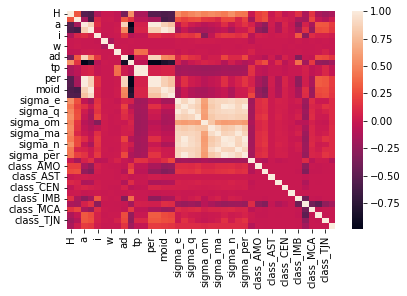

In [21]:
sns.heatmap(data_neo.corr())

<AxesSubplot:>

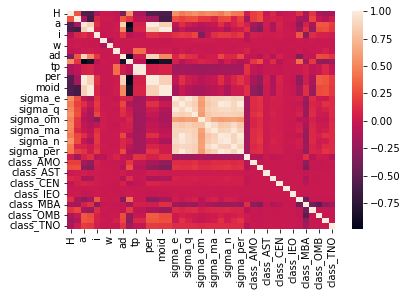

In [22]:
sns.heatmap(data_pha.corr())

In [23]:
from sklearn.model_selection import GridSearchCV

X = data_neo.drop(axis=1, columns=['neo']).to_numpy()
y = data_neo['neo'].to_numpy().astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.08, test_size=0.02, random_state=seed, shuffle=True)

In [24]:
len(y_train)

76681

In [25]:
model = RandomForestClassifier()
# n_estimators, criterion, max_depth,
# min_samples_split oraz min_samples_leaf
parameters = {'n_estimators': [10, 100, 1000],
              'criterion': ['entropy', 'gini'],
              'max_depth': [1, 100, len(X_train)],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2]
              }
clf = GridSearchCV(model, parameters, cv=3, n_jobs=-1, verbose=3)

In [26]:
ttt = time.perf_counter()
clf.fit(X_train, y_train)
print(time.perf_counter() - ttt)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
781.2007322999998


In [27]:
print(clf.best_params_)

{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
y_predicted = clf.predict(X_test)

Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0


<Figure size 720x720 with 0 Axes>

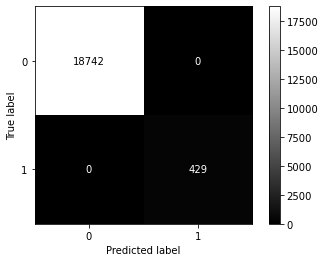

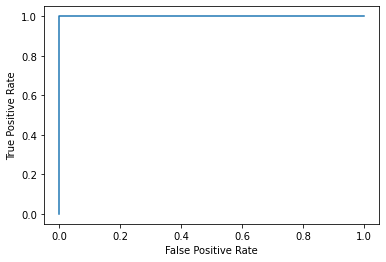

In [29]:
plt.figure(figsize=(10, 10))

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='gray')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

In [30]:
from sklearn.model_selection import GridSearchCV

X = data_pha.drop(axis=1, columns=['pha']).to_numpy()
y = data_pha['pha'].to_numpy().astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.08, test_size=0.02, random_state=seed, shuffle=True)

In [31]:
model = RandomForestClassifier()
# n_estimators, criterion, max_depth,
# min_samples_split oraz min_samples_leaf
parameters = {'n_estimators': [10, 100, 1000],
              'criterion': ['entropy', 'gini'],
              'max_depth': [1, 100, len(X_train)],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2]
              }
clf = GridSearchCV(model, parameters, cv=3, n_jobs=-1, verbose=3)

In [32]:
ttt = time.perf_counter()
clf.fit(X_train, y_train)
print(time.perf_counter() - ttt)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
605.4451858000248


In [35]:
print(clf.best_params_)

{'criterion': 'entropy', 'max_depth': 75088, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [33]:
y_predicted = clf.predict(X_test)

Czulosc: 0.9375
Swoistosc: 0.9994664105437276
Accuracy: 0.9993607841048314
ROC auc: 0.874946618267229
F1 score: 0.8333333333333334
BA score: 0.874946618267229


<Figure size 720x720 with 0 Axes>

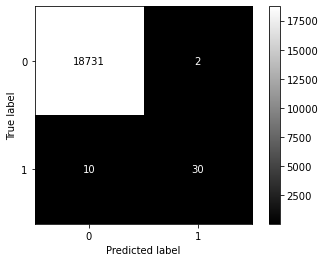

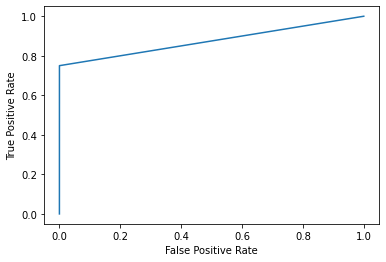

In [34]:
plt.figure(figsize=(10, 10))

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='gray')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

In [40]:
from sklearn.model_selection import GridSearchCV

X = data_neo.drop(axis=1, columns=['neo']).to_numpy()
y = data_neo['neo'].to_numpy().astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=seed, shuffle=True)

In [41]:
model = RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100)

model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100)

In [42]:
y_predicted = model.predict(X_test)

Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0


<Figure size 720x720 with 0 Axes>

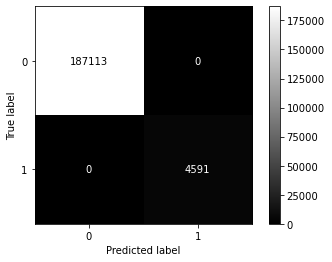

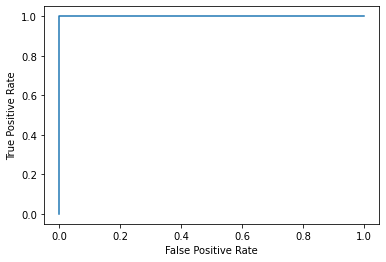

In [43]:
plt.figure(figsize=(10, 10))

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='gray')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

In [44]:
from sklearn.model_selection import GridSearchCV

X = data_pha.drop(axis=1, columns=['pha']).to_numpy()
y = data_pha['pha'].to_numpy().astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=seed, shuffle=True)

In [45]:
model = RandomForestClassifier(criterion='entropy', max_depth=75088, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=75088)

In [46]:
y_predicted = model.predict(X_test)

Czulosc: 0.8659217877094972
Swoistosc: 0.9994182415951922
Accuracy: 0.9991636524416554
ROC auc: 0.8698002656437657
F1 score: 0.7979407979407979
BA score: 0.8698002656437657


<Figure size 720x720 with 0 Axes>

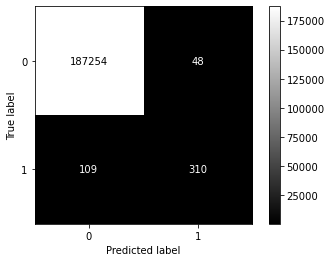

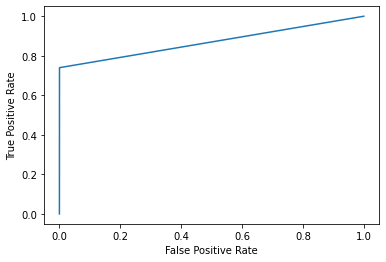

In [47]:
plt.figure(figsize=(10, 10))

cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='gray')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))

# Wnioski

Wybrane parametry dla NEO oraz PHA nie byly takie same

In [48]:
 ! jupyter nbconvert --to html lab6cz2.ipynb

[NbConvertApp] Converting notebook lab6cz2.ipynb to html
[NbConvertApp] Writing 817574 bytes to lab6cz2.html
